In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# from skimage import io
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers import BatchNormalization
import seaborn as sn

from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
filname = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [3]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [4]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


# keras with tensorflow backend 

In [5]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [13]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # model.summary()
    
    return model
model=my_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

In [16]:
path_model='model_filter.h5' # save model at this location after each epoch
K.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Epoch 1/20


505/505 [==============================] - ETA: 0s - loss: 1.6515 - accuracy: 0.3583

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


505/505 [==============================] - 396s 777ms/step - loss: 1.6515 - accuracy: 0.3583 - val_loss: 1.6450 - val_accuracy: 0.3455
Epoch 2/20
505/505 [==============================] - 395s 783ms/step - loss: 1.2834 - accuracy: 0.5105 - val_loss: 1.4330 - val_accuracy: 0.4712
Epoch 3/20
505/505 [==============================] - 344s 681ms/step - loss: 1.1114 - accuracy: 0.5816 - val_loss: 1.3652 - val_accuracy: 0.4951
Epoch 4/20
505/505 [==============================] - 375s 743ms/step - loss: 0.9947 - accuracy: 0.6297 - val_loss: 1.1435 - val_accuracy: 0.5626
Epoch 5/20
505/505 [==============================] - 315s 623ms/step - loss: 0.8714 - accuracy: 0.6770 - val_loss: 1.1482 - val_accuracy: 0.5715
Epoch 6/20
505/505 [==============================] - 309s 611ms/step - loss: 0.7364 - accuracy: 0.7287 - val_loss: 1.2045 - val_accuracy: 0.5748
Epoch 7/20
505/505 [==============================] - 310s 613ms/step - loss: 0.5879 - accuracy: 0.7874 - val_loss: 1.2761 - val_accura

In [18]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [19]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [21]:
y_pred=model.predict(X_test)
print(y_pred)
y_test.shape

113/113 [==============================] - 11s 93ms/step
[[1.58637917e-07 1.29266171e-08 4.14357721e-08 ... 1.26126892e-07
  1.10471575e-07 2.01076944e-07]
 [7.37397186e-03 6.24997192e-05 1.94106326e-02 ... 7.64955953e-02
  8.80339026e-01 1.59122776e-02]
 [1.37569048e-04 4.22258779e-08 1.05054169e-05 ... 1.57116048e-07
  9.38347161e-01 4.53065336e-03]
 ...
 [5.72669601e-09 1.06393387e-07 3.20512317e-02 ... 9.66614783e-01
  1.12537790e-09 1.29947253e-03]
 [5.61053157e-01 3.93516650e-08 1.83504555e-04 ... 2.22874060e-01
  4.81207576e-03 2.11075947e-01]
 [6.75577998e-01 5.67908387e-08 3.23801666e-01 ... 3.96194491e-06
  1.34438786e-04 1.85078861e-05]]


(3589, 7)

1/1 [==============================] - ETA: 0s

c:\Python311\Lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 27ms/step


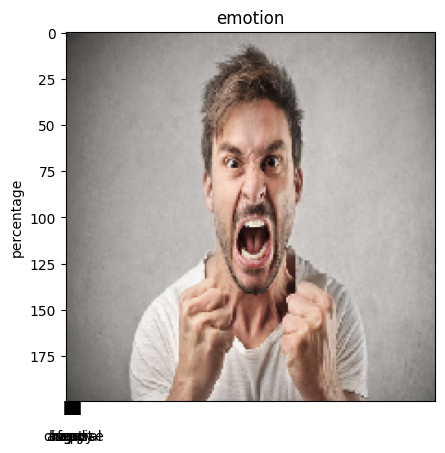

Expression Prediction: fear


In [33]:

img = image.load_img('angry.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('angry.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48])

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
